In [17]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [18]:
# loading dataset 
train_features = np.load('/content/drive/MyDrive/Industrial Team Project/Dataset/UTD_npy/Data/UCI_train_features.npy')
test_features = np.load('/content/drive/MyDrive/Industrial Team Project/Dataset/UTD_npy/Data/UCI_test_features.npy')
train_labels = np.load('/content/drive/MyDrive/Industrial Team Project/Dataset/UTD_npy/Data/UCI_train_labels.npy')
test_labels = np.load('/content/drive/MyDrive/Industrial Team Project/Dataset/UTD_npy/Data/UCI_test_labels.npy')

In [19]:
train_dataset = TensorDataset(torch.from_numpy(train_features).to(torch.float32),torch.from_numpy(train_labels).to(torch.float32))

test_dataset = TensorDataset(torch.from_numpy(test_features).to(torch.float32),torch.from_numpy(test_labels).to(torch.float32))


In [20]:
train_loader = data.DataLoader(dataset = train_dataset,batch_size = 64,shuffle = True)

test_loader = data.DataLoader(dataset = test_dataset,batch_size = 64,shuffle = False)

In [21]:
class CNN_UTD(nn.Module):
  def __init__(self):
    super(CNN_UTD, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU()
    )
    # self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(8448, 512)
    self.fc3 = nn.Linear(512,12)
  def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc3(out)
        return out
        
model = CNN_UTD().to(device)

In [22]:
epoches = 100
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [23]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,36)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  79.3525571273123  % Loss:  0.5381907052319983
Epoch:  2 accuracy:  88.57453754080522  % Loss:  0.32947501747504526
Epoch:  3 accuracy:  89.25462459194777  % Loss:  0.3011733480769655
Epoch:  4 accuracy:  89.56746463547334  % Loss:  0.2819562227829643
Epoch:  5 accuracy:  90.26115342763873  % Loss:  0.2617013375396314
Epoch:  6 accuracy:  90.23394994559304  % Loss:  0.2538442908421807
Epoch:  7 accuracy:  90.65560391730142  % Loss:  0.24702722618113393
Epoch:  8 accuracy:  90.73721436343853  % Loss:  0.2347573621765427
Epoch:  9 accuracy:  90.96844396082699  % Loss:  0.23000760583773902
Epoch:  10 accuracy:  91.19967355821545  % Loss:  0.22671033882576486
Epoch:  11 accuracy:  91.36289445048966  % Loss:  0.2200830808152323
Epoch:  12 accuracy:  91.63492927094669  % Loss:  0.2173224708956221
Epoch:  13 accuracy:  91.47170837867247  % Loss:  0.21478168886640797
Epoch:  14 accuracy:  91.60772578890098  % Loss:  0.21477322973634885
Epoch:  15 accuracy:  92.0565832426550

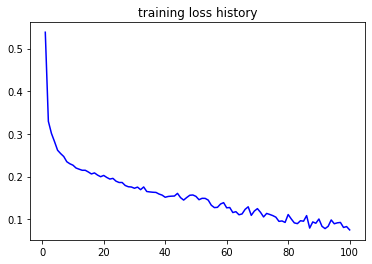

In [25]:
import matplotlib.pyplot as plt
x = []
for i in range(1,101):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [26]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,36)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  83.5086528673227
